In [15]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model

import numpy as np
import time

LOAD DATABASES, CONCATENATE AND MIX THEM

In [27]:
sss = time.time()
rv = [18.]
nr = len(rv)
paths = []
for r in rv:
    paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")

n_traj = 50000
db = np.ndarray(shape=(nr*n_traj,2000,1))
labels = []
for path,r,i in zip(paths,rv,range(nr)):
    db1 = np.load(path)
    for j in range(n_traj):
        db[i*n_traj + j,:,0] = db1[j,0,:]
        labels.append(r)

labels = np.array(labels)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

db, labels = unison_shuffled_copies(db, labels)

print(f'time: {time.time() - sss:.1f}')

time: 2.8


PREPROCESSING

In [28]:
sig_len = len(db[0,:,0])
print(f"siglen: {sig_len}")
channels = 1 #len(db[0,0,:])
print(f"channels: {channels}")
n_traj = len(db[:,0,0])
print((f"n_traj: {n_traj}"))
validation_split = 0.33
first_validation = round((1. - validation_split)*n_traj)
print(f"first_validation: {first_validation}")
db_train = np.ndarray(shape=(first_validation,sig_len,channels))
db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
db_train = db[:first_validation,:,0:channels]
db_test = db[first_validation:,:,0:channels]
del db


print(db_train.shape)
M = np.max(np.append(db_train, db_test))
m = np.min(np.append(db_train, db_test))
print(M,m)
db_train = (db_train - m)/(M - m)
db_test = (db_test - m)/(M - m)
M = np.max(db_train)
m = np.min(db_test)
print(M,m)

siglen: 2000
channels: 1
n_traj: 50000
first_validation: 33500
(33500, 2000, 1)
18.01540074798299 -18.031624945549105
1.0 0.0


VISUALIZE DATA

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

def plot_trajs(noise, epoch=None):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    plt.figure(figsize=(18, 8))
    for i, traj in enumerate(gen_trajs):
        plt.subplot(5, 5, i+1)
        plt.plot(traj)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    #fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ##epoch = fit_history.history
    #epoch = fit_history.history
    #ax1.set_xlabel("epochs")
    #ax2.set_xlabel("epochs")
    #plt.yscale('log')
    #ax1.plot(epoch['loss'], color="b",label="training_loss")
    #ax1.plot(epoch['val_loss'], color="r",label="validation_loss")
    #ax1.legend()
    #ax2.plot(epoch['acc'], color="b",label="training_accuracy")
    #ax2.plot(epoch['val_acc'], color="r",label="validation_accuracy")
    #ax2.legend()

#n = round(np.random.uniform(first_validation))
##n = 35368
#print(n)
#traj = db_train[n,:,:]
#plt.plot(traj[:,0])
##plt.plot(traj[:,1])
##plt.plot(traj[:,2])
#plt.show()


ARCHITETTURA RETE NEURALE

In [29]:
class Conv1DTranspose(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', kernel_initializer=RandomNormal(0, 0.02)):
        super().__init__()
        self.conv2dtranspose = tensorflow.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=RandomNormal(0, 0.02)
        )

    def call(self, x):
        x = tensorflow.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tensorflow.squeeze(x, axis=2)
        return x

noise_dim = 100
optimizer = Adam(0.0002, 0.5)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel

def create_gen():
    generator = Sequential()
    
    # Starting size
    d = 10
    generator.add(Dense(d*8, activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(Reshape((d, fm)))
    
    generator.add(Conv1DTranspose(4, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    
    generator.add(Conv1DTranspose(2, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    
    generator.add(Conv1DTranspose(1, fs, strides=8, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        
    generator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return generator

gen = create_gen()

In [30]:
gen.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 80)                8080      
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 8)             0         
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 50, 4)             644       
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 250, 2)            162       
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 2000, 1)           41        
Total params: 8,927
Trainable params: 8,927
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer = Adam(0.0002, 0.5)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel
def create_desc():
    discriminator = Sequential()
    #input:2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
    #input:250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    #input:32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))
    #input:8x8
    discriminator.add(Flatten())
    #8000x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #discriminator.add(Dropout(0.1))
    discriminator.add(Dense(1, activation='softmax'))
    #discriminator.add(Dropout(0.1))
    #4x1
    discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return discriminator

desc = create_desc()

In [32]:
desc.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 250, 8)            168       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 8)             1288      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 8)              1288      
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 6,969
Trainable params: 6,969
Non-trainable params: 0
____________________________________________________

In [33]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
desc.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_traj = gen(gan_input)

gan_output = desc(fake_traj)

gan = Model(gan_input, gan_output)
optimizer = Adam(0.0002, 0.5)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

TRAINING

In [37]:
desc_loss

[8.433281, 0.0]

In [34]:
static_noise = np.random.normal(0, 1, size=(25, noise_dim))
epochs = 5
steps_per_epoch = 1000
batch_size = 50
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        real_x = db_train[np.random.randint(0, db_train.shape[0], size=batch_size)]
        fake_x = gen.predict(noise)
        x = np.concatenate((real_x, fake_x))
        desc_labels = np.zeros(2*batch_size)
        desc_labels[:batch_size] = 0.9

        desc_loss = desc.train_on_batch(x, desc_labels)

        gen_labels = np.ones(batch_size)
        gen_loss = gan.train_on_batch(noise, gen_labels)
        print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}','%.2f'%(batch/steps_per_epoch), end="\r")
        
    print(f'Epoch: {epoch} \t Discriminator Loss: {desc_loss} \t\t Generator Loss: {gen_loss}')
    #plot_trajs(static_noise)

#history = LossHistory()
#fit_history = desc.fit(db, labels, batch_size=256, epochs=20, verbose=1, validation_split=0.33,
#                       shuffle=False, callbacks=[history])

W0325 22:40:08.571858 47874792689152 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0325 22:40:08.709550 47874792689152 deprecation.py:323] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0 	 Discriminator Loss: [8.433281, 0.0] 		 Generator Loss: -0.0
Epoch: 1 	 Discriminator Loss: [8.433281, 0.0] 		 Generator Loss: -0.0


KeyboardInterrupt: 

In [64]:
desc.save('classificatore.h5')
#from tensorflow.keras.models import load_model
#desc = load_model('classificatore.h5')

TESTING

In [61]:
#n = round(np.random.uniform(0,10000))
desc.evaluate(db,labels)
#output = desc.predict(db[n:n+1000])
#for i in range(100):
#    print(f'{n+i:4}',end="\t")
#    print(f'{output[i][0]:1.2g}',end="\t")
#    print(f'{output[i][1]:1.2g}',end="\t")
#    print(f'{labels[n+i]:3}')

200000/200000 [==============================] - 8s 42us/sample - loss: 0.0821 - acc: 0.9755


[0.08214032410897315, 0.97548]

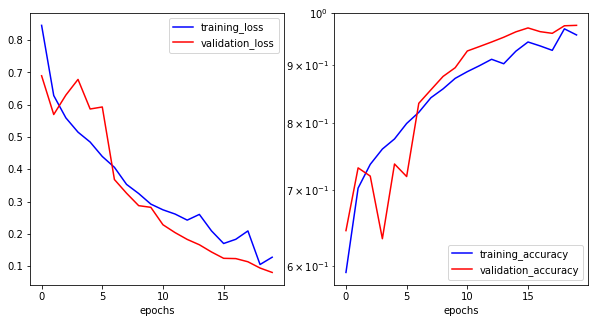

In [62]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
#epoch = fit_history.history
epoch = fit_history.history
ax1.set_xlabel("epochs")
ax2.set_xlabel("epochs")
plt.yscale('log')
ax1.plot(epoch['loss'], color="b",label="training_loss")
ax1.plot(epoch['val_loss'], color="r",label="validation_loss")
ax1.legend()
ax2.plot(epoch['acc'], color="b",label="training_accuracy")
ax2.plot(epoch['val_acc'], color="r",label="validation_accuracy")
ax2.legend()

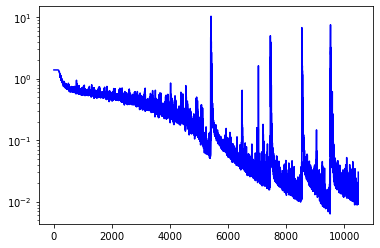

In [11]:
#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#epoch = fit_history.history
losses = history.losses
val_losses = history.val_losses
plt.yscale('log')
plt.plot(losses, color="b")
plt.plot(val_losses, color="r")
#ax2.plot(epoch['acc'], color="b")
#ax2.plot(epoch['val_acc'], color="r")

In [12]:
a = desc.get_weights()
for i in range(8): 
    print( a[i].shape )

(10, 1, 8)
(8,)
(10, 8, 8)
(8,)
(10, 8, 8)
(8,)
(64, 64)
(64,)


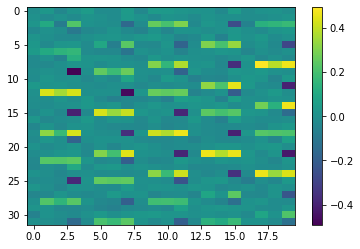

In [18]:
ciccio = a[2].reshape(32,-1)
import matplotlib.pyplot as plt
plt.imshow(ciccio, aspect="auto")
plt.colorbar()